# DNABERT 불러오기

## 모델 준비

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
print("GPU 사용 가능 여부:", torch.cuda.is_available())
print("사용 중인 GPU 이름:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "사용 불가")

GPU 사용 가능 여부: True
사용 중인 GPU 이름: NVIDIA A100-SXM4-40GB


In [3]:
# 2. GitHub에서 DNABERT-2 레포지토리 클론
!git clone https://github.com/MAGICS-LAB/DNABERT_2.git
%cd DNABERT_2

Cloning into 'DNABERT_2'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 123 (delta 28), reused 32 (delta 17), pack-reused 66 (from 1)
Receiving objects: 100% (123/123), 879.11 KiB | 6.71 MiB/s, done.
Resolving deltas: 100% (51/51), done.
/content/DNABERT_2


In [4]:
# 3. 필요한 패키지 설치
!python3 -m pip install -r requirements.txt
!pip uninstall -y tensorflow

# 설치된 transformer와 torch 버전 확인
import transformers
print("Transformers 버전:", transformers.__version__)
print("torch 버전:", torch.__version__)

!pip list | grep transformers
!pip list | grep torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 119.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 87.3 MB/s eta 0:00:00
   ━━━━━

## fine-tuning된 정보 불러오기

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# 저장된 모델 경로 설정
checkpoint_path = "./OUTPUT/checkpoint" # 저장된 가장 성능 높은 모델 (fine-tuning)

# 데이터 로드
data = pd.read_csv("./INPUT/test.csv")  # test.csv 파일 경로

# 모델과 토크나이저 불러오기
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path, trust_remote_code=True)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path, trust_remote_code=True)

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# Classification (onlyDNABERT)

In [7]:
# 데이터 추론 함수
def predict_dna_sequences(model, tokenizer, sequences, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for seq in sequences:
            # 토크나이저로 입력 변환
            inputs = tokenizer(seq, return_tensors="pt", truncation=True, padding=True, max_length=512)
            inputs = {key: val.to(device) for key, val in inputs.items()}

            # 모델 추론
            outputs = model(**inputs)
            logits = outputs.logits
            pred_label = torch.argmax(logits, dim=-1).item()
            predictions.append(pred_label)
    return predictions

# 추론 실행
sequences = data['sequence'].tolist()  # sequence 컬럼 데이터
predicted_labels = predict_dna_sequences(model, tokenizer, sequences, device)

# 결과 확인
data['predicted_label'] = predicted_labels
print(data[['sequence', 'predicted_label']])


                                                sequence  predicted_label
0      [CLS] ACACCAGGGCAGAAGCAGCAGTCAGTAAGCTATGAAATAC...                0
1      [CLS] CTTCTACATGCAGAACATCGACCAGGACATGCGTGACGAC...                1
2      [CLS] GTCTCTGCCCCTCCCAGGTCCTGGTGATCCGGCTTCGGGA...                0
3      [CLS] CTTTGACGGTCCCCGAGGCCACGGTGAAAGACAGTGGAGA...                1
4      [CLS] GTTGGTACGAAGTTAATCAGAGTTACAGCAATAGATGACA...                1
...                                                  ...              ...
16012  [CLS] GGTTTAATATTCAACGATATGAATCTCCACTAAGGATAAA...                0
16013  [CLS] TCCACAAGAAATGGAAGTAGATAGTGAAGATGAAAAGGAT...                1
16014  [CLS] TCGAGAAGGGATGCTTTTCATTTCCAAACTGGATGGGCGT...                1
16015  [CLS] GGCCCCGACCGCGTGCTGGAGCTCTTCGACCCACCCAAGA...                1
16016  [CLS] CACACCTAATTTGCCTCACCACCAAAACGGCCATCTTCAG...                1

[16017 rows x 2 columns]


In [10]:
save_data = data[['label', 'predicted_label']]
save_data.head()


,label,predicted_label
0,0,0
1,0,1
2,0,0
3,1,1
4,1,1


In [11]:
## 결과 저장
save_data.to_csv('./prediction_output_only.csv', index=False)

print(f"Prediction results saved to {save_data}")

Prediction results saved to        label  predicted_label
0          0                0
1          0                1
2          0                0
3          1                1
4          1                1
...      ...              ...
16012      0                0
16013      1                1
16014      1                1
16015      1                1
16016      1                1

[16017 rows x 2 columns]


# 모델 성능 평가

In [9]:
# 모델 성능 평가 (테스트 데이터에 실제 라벨이 있는 경우)
from sklearn.metrics import classification_report

true_labels = data['label'].tolist()  # 실제 라벨 (test.csv에 포함된 경우)
print("[ Only DNABERT ]",'\n')
print(classification_report(true_labels, predicted_labels))

[ Only DNABERT ] 

              precision    recall  f1-score   support

           0       0.99      0.83      0.90      8054
           1       0.85      0.99      0.92      7963

    accuracy                           0.91     16017
   macro avg       0.92      0.91      0.91     16017
weighted avg       0.92      0.91      0.91     16017



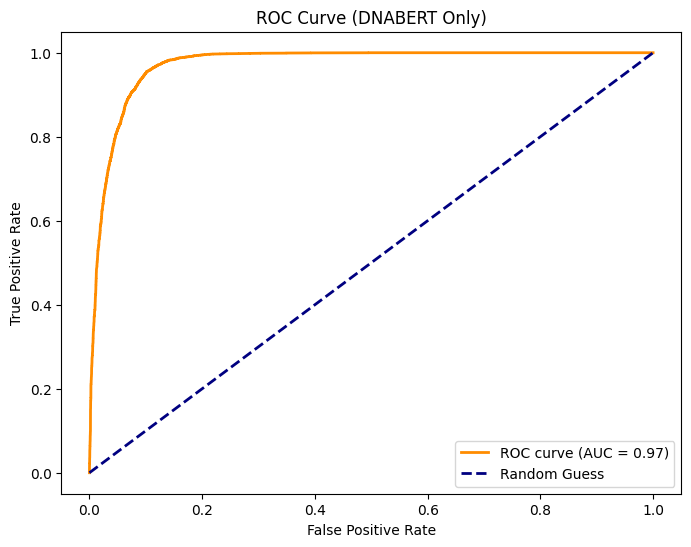

AUC (Area Under the Curve): 0.9720


In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# 데이터 추론 함수 (확률 반환 버전)
def predict_dna_sequences_with_probs(model, tokenizer, sequences, device):
    model.eval()
    probabilities = []
    with torch.no_grad():
        for seq in sequences:
            # 토크나이저로 입력 변환
            inputs = tokenizer(seq, return_tensors="pt", truncation=True, padding=True, max_length=512)
            inputs = {key: val.to(device) for key, val in inputs.items()}

            # 모델 추론
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=-1).squeeze().cpu().numpy()  # 확률 계산
            probabilities.append(probs)
    return np.array(probabilities)

# 확률 기반 추론 실행
predicted_probabilities = predict_dna_sequences_with_probs(model, tokenizer, sequences, device)
# predicted_probabilities = np.array(predicted_labels)

# 클래스 1에 해당하는 확률 추출
class_1_probabilities = predicted_probabilities[:, 1]

# ROC Curve 계산
fpr, tpr, thresholds = roc_curve(true_labels, class_1_probabilities)
roc_auc = auc(fpr, tpr)

# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (DNABERT Only)')
plt.legend(loc='lower right')
plt.grid(False)
plt.show()

# AUC 출력
print(f"AUC (Area Under the Curve): {roc_auc:.4f}")